In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import yaml
import json
import warnings
import pprint

In [2]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Metrics to look at:
* Metrics over time
* Comparison of Hyperparameters
* Metrics at the beginning of training:
    * Why does scaling embeddings screw things up so much? Even when it's just the initialization --> must be an issue at the beginning of training, could be something interesting to look into

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

show_all = pd.option_context('display.max_colwidth', 999)

In [4]:
def load_yaml(path):
    with open(path, 'r') as f:
        return yaml.safe_load(f)
def load_json(path):
    with open(path, 'r') as f:
        return json.load(f)

In [5]:
model_path = '../models/factorization/2^16/'

In [6]:
def flatten_config(config_item):
    expanded = {}
    expanded['base'] = config_item['data']['base']
    expanded['train_data'] = config_item['data']['train_path']
    expanded['train_batch_size'] = config_item['loader']['train']['batch_size']
    for k, v in config_item['model_args'].items():
        expanded[k] = v
    if not 'embedding_initialization' in expanded:
        expanded['embedding_initialization'] = 'normal'
    expanded['optimizer'] = config_item['optimizer']['type']
    for k, v in config_item['optimizer']['opt_args'].items():
        expanded[k] = v
    if not 'weight_decay' in expanded:
        expanded['weight_decay'] = 0
    expanded['gradient_accumulation_steps'] = config_item['optimizer']['gradient_accumulation_steps']
#     handle all model args
#     handle all opt args
    try:
        expanded['num_warmup_steps'] = config_item['scheduler']['n_warmup_steps']
    except KeyError:
        expanded['num_warmup_steps'] = config_item['scheduler']['scheduler_args']['num_warmup_steps']
    expanded['nb_epochs'] = config_item['scheduler']['nb_epochs']
    expanded['max_grad_norm'] = config_item['optimizer']['max_grad_norm']
    
    expanded['effective_train_batch_size'] = expanded['train_batch_size'] * expanded['gradient_accumulation_steps']
    del expanded['train_batch_size']
    del expanded['gradient_accumulation_steps']
    
    
    return expanded

In [7]:
config_list = []
test_metric_list = []
oos_metric_list = []
loss_hist_list = []
test_factor_df_list = []
run_names = []


def find_metrics_in_dir(base_path):
    for f in os.listdir(base_path):
        print(f)
        if f in ['300s', '.gitignore', 'addition_baselines', 'addition_small_as_possible']: continue
        print(f)
        run_names.append(f)
        subdir_path = base_path + f + '/'
        
        if os.path.exists(subdir_path + 'checkpoints/'):
            config_path = subdir_path + 'config.yaml'
            metrics_path = subdir_path + 'metrics_test.json'
            metrics_oos_path = subdir_path + 'metrics_oos.json'
            loss_hist_path = subdir_path + 'loss_hist.csv'
            
            if not os.path.exists(metrics_path):
                print(f'FAILED TO LOAD {f}')
                continue

            config_list.append(load_yaml(config_path))
            test_metric_list.append(load_json(metrics_path))
            oos_metric_list.append(load_json(metrics_oos_path))
            loss_hist_list.append(pd.read_csv(loss_hist_path))
            
            test_factor_df_list.append(pd.read_csv(subdir_path + 'pred_df_test.csv'))
            
        elif os.path.isdir(subdir_path) and not f=='checkpoints':
            find_metrics_in_dir(subdir_path)

In [8]:
find_metrics_in_dir(model_path)

10_enc_dec_layers
10_enc_dec_layers
12_enc_dec_layers
12_enc_dec_layers
16_enc_dec_layers
16_enc_dec_layers
2_enc_dec_layers
2_enc_dec_layers
30_10_enc_dec_layers
30_10_enc_dec_layers
30_12_enc_dec_layers
30_12_enc_dec_layers
30_16_enc_dec_layers
30_16_enc_dec_layers
30_2_enc_dec_layers
30_2_enc_dec_layers
30_4_enc_dec_layers
30_4_enc_dec_layers
30_8_enc_dec_layers
30_8_enc_dec_layers
4_enc_dec_layers
4_enc_dec_layers
8_enc_dec_layers
8_enc_dec_layers
abs_pes
abs_pes
abs_pes_repeat
abs_pes_repeat
abs_pes_repeat_qk_only
abs_pes_repeat_qk_only
abs_pes_repeat_qk_only_learn
abs_pes_repeat_qk_only_learn
baseline
baseline
base_2
base_2
base_3
base_3
base_30
base_30
base_7
base_7
dim_feedforward_1024
dim_feedforward_1024
dim_feedforward_128
dim_feedforward_128
dim_feedforward_2048
dim_feedforward_2048
dim_feedforward_256
dim_feedforward_256
embed_dim_1024
embed_dim_1024
embed_dim_256
embed_dim_256
embed_dim_512
embed_dim_512
embed_dim_64
embed_dim_64
epochs_400
epochs_400
epochs_400_more_drop

In [9]:
configs = [flatten_config(c) for c in config_list]
config_df = pd.DataFrame.from_dict(configs)

In [10]:
config_df.shape

(50, 27)

In [11]:
test_metric_list[0]['correct']

{'correct_product': 0.9473284760170007,
 'correct_factorization': 0.7615361262902246}

In [12]:
def get_nice_metrics(metric_list, suffix = '', just_factorization=True):
    if just_factorization:
        correct = pd.DataFrame.from_dict([{'correct_factorization' : l['correct']['correct_factorization']} for l in metric_list])
    else:
        correct = pd.DataFrame.from_dict([l['correct'] for l in metric_list])
    n_beams = pd.DataFrame.from_dict([l['meta']['n_beams'] for l in metric_list])
    
    def get_loss(metric_dict):
        try:
            return metric_dict['loss']
        except KeyError:
            return metric_dict['test_loss']
        
    loss_df = pd.DataFrame.from_dict([get_loss(l) for l in metric_list])
    
    n_beams.columns = ['n_beams']
    loss_df.columns = ['loss']
    to_return = [correct, n_beams, loss_df]
    if suffix:
        for tmp_df in to_return:
            tmp_df.columns = [str(c) + f'_{suffix}' for c in tmp_df.columns]
    return to_return

In [13]:
use_entries = []
use_backup = []
for name in run_names:
    other_name = "_".join(name.split('_')[:-1])
    if name.endswith('_BACKUP') and other_name in run_names:
        use_entries.append(other_name)
        use_backup.append(name)

In [14]:
t = pd.DataFrame({
    'new' : [x['correct']['correct_factorization'] for n, x in zip(run_names, test_metric_list) if n in use_entries],
    'old' : [x['correct']['correct_factorization'] for n, x in zip(run_names, test_metric_list) if n in use_backup]
})

In [15]:
merged = pd.concat([config_df] + get_nice_metrics(test_metric_list, 'test') + get_nice_metrics(oos_metric_list, 'oos') + 
                   [pd.DataFrame({'loss_hist' : loss_hist_list})], axis=1)

In [16]:
ignore_cols = ['loss_hist']

In [17]:
merged.iloc[:,:-1]

,base,train_data,attn_weight_xavier_init_constant,dim_feedforward,dropout,embed_dim,embedding_initialization,extra_positional_encoding_relative_decoder_mha,learn_positional_encoding,max_decode_size,...,nb_epochs,max_grad_norm,effective_train_batch_size,num_heads,correct_factorization_test,n_beams_test,loss_test,correct_factorization_oos,n_beams_oos,loss_oos
0,10,data/train_data_2^16.npy,0.5,512,0.050,128,xavier,True,False,64,...,200,1,256,NaN,0.761536,2,0.176904,0.574707,2,0.379060
1,10,data/train_data_2^16.npy,0.5,512,0.050,128,xavier,True,False,64,...,200,1,256,NaN,0.738312,2,0.187206,0.546875,2,0.383010
2,10,data/train_data_2^16.npy,0.5,512,0.050,128,xavier,True,False,64,...,200,1,256,NaN,0.687007,2,0.215617,0.464844,2,0.421082
3,10,data/train_data_2^16.npy,0.5,512,0.050,128,xavier,True,False,64,...,200,1,256,NaN,0.372495,2,0.376533,0.281738,2,0.494908
4,30,data/train_data_2^16.npy,0.5,512,0.050,128,xavier,True,False,64,...,200,1,256,NaN,0.862477,2,0.135687,0.675781,2,0.420128
5,30,data/train_data_2^16.npy,0.5,512,0.050,128,xavier,True,False,64,...,200,1,256,NaN,0.861111,2,0.143742,0.690430,2,0.403105
6,30,data/train_data_2^16.npy,0.5,512,0.050,128,xavier,True,False,64,...,200,1,256,NaN,0.847450,2,0.148542,0.586426,2,0.508830
7,30,data/train_data_2^16.npy,0.5,512,0.050,128,xavier,True,False,64,...,200,1,256,NaN,0.585458,2,0.280994,0.373535,2,0.511091
8,30,data/train_data_2^16.npy,0.5,512,0.050,128,xavier,True,False,64,...,200,1,256,NaN,0.796448,2,0.167263,0.566895,2,0.442286
9,30,data/train_data_2^16.npy,0.5,512,0.050,128,xavier,True,False,64,...,200,1,256,NaN,0.868094,2,0.140810,0.651855,2,0.440531


In [18]:
assert (merged['n_beams_test']==merged['n_beams_oos']).all()
merged['n_beams'] = merged['n_beams_oos']
merged.drop(['n_beams_test', 'n_beams_oos'], axis=1, inplace=True)

In [19]:
# Drop all confiuraiton columns that have no variantion b/c that's not super helpful
drop_cols = []
for c in list(config_df) + ['n_beams']:
    if not c in merged: continue
    if merged[c].nunique()==1:
        drop_cols.append(c)
print('Dropping: ', drop_cols)
metric_df_loss_hist = merged.drop(drop_cols, axis=1)
metric_df = metric_df_loss_hist.copy()
metric_df.drop('loss_hist', axis=1, inplace=True)

Dropping:  ['train_data', 'embedding_initialization', 'max_decode_size', 'optimizer', 'lr', 'max_grad_norm', 'effective_train_batch_size', 'n_beams']


In [20]:
metrics = ['correct_factorization', 'loss']
splits = ['test', 'oos']
metrics_full = [f'{metric}_{split}' for split in splits for metric in metrics]

In [21]:
metrics_full

['correct_factorization_test',
 'loss_test',
 'correct_factorization_oos',
 'loss_oos']

In [22]:
metric_df

,base,attn_weight_xavier_init_constant,dim_feedforward,dropout,embed_dim,extra_positional_encoding_relative_decoder_mha,learn_positional_encoding,norm_first,num_decoder_layers,num_encoder_layers,...,scale_embeddings_at_init,shared_embeddings,weight_decay,num_warmup_steps,nb_epochs,num_heads,correct_factorization_test,loss_test,correct_factorization_oos,loss_oos
0,10,0.5,512,0.050,128,True,False,False,10,10,...,False,True,0.10,6000,200,NaN,0.761536,0.176904,0.574707,0.379060
1,10,0.5,512,0.050,128,True,False,False,12,12,...,False,True,0.10,6000,200,NaN,0.738312,0.187206,0.546875,0.383010
2,10,0.5,512,0.050,128,True,False,False,16,16,...,False,True,0.10,6000,200,NaN,0.687007,0.215617,0.464844,0.421082
3,10,0.5,512,0.050,128,True,False,False,2,2,...,False,True,0.10,6000,200,NaN,0.372495,0.376533,0.281738,0.494908
4,30,0.5,512,0.050,128,True,False,False,10,10,...,False,True,0.10,6000,200,NaN,0.862477,0.135687,0.675781,0.420128
5,30,0.5,512,0.050,128,True,False,False,12,12,...,False,True,0.10,6000,200,NaN,0.861111,0.143742,0.690430,0.403105
6,30,0.5,512,0.050,128,True,False,False,16,16,...,False,True,0.10,6000,200,NaN,0.847450,0.148542,0.586426,0.508830
7,30,0.5,512,0.050,128,True,False,False,2,2,...,False,True,0.10,6000,200,NaN,0.585458,0.280994,0.373535,0.511091
8,30,0.5,512,0.050,128,True,False,False,4,4,...,False,True,0.10,6000,200,NaN,0.796448,0.167263,0.566895,0.442286
9,30,0.5,512,0.050,128,True,False,False,8,8,...,False,True,0.10,6000,200,NaN,0.868094,0.140810,0.651855,0.440531


In [23]:
def make_correlation_plot(metric_df, x, y, clip_outliers = True):
    x_col = metric_df[x]
    y_col = metric_df[y]
    
    is_outlier = (x_col > x_col.mean() + x_col.std() * 5) | (x_col < x_col.mean() - x_col.std() * 5)
    x_col = x_col[~is_outlier]
    y_col = y_col[~is_outlier]
    
    metric_df[~is_outlier].plot.scatter(x=x, y=y)
    
    m, b = np.polyfit(x_col, y_col, 1)
    ax = plt.gca()
    x_vals = np.array(ax.get_xlim())
    plt.plot(x_vals, m*x_vals + b, color='black', linestyle='--', alpha=.5)
    plt.title(f'Correlation between {x} and {y}')
    plt.show()

### Look at some correlations
#### In general:
* Correlation using correct_product is not very strong in many places.
    * I think this makes sense because of the issue where when the model is unable to factor the number, it returns the number because it could be prime

#### Test metrics vs OoS Metrics:
* Test loss is very correlated with Oos. Same for factorization, but not quite as much

#### Is loss correlated of correct factorizatoin?
* Yes! Loss is very correlated with correct factorization

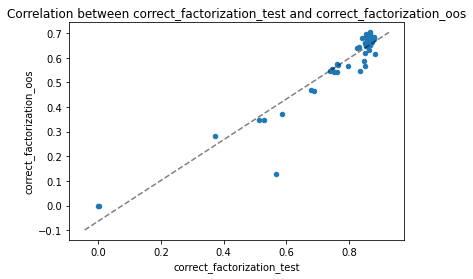

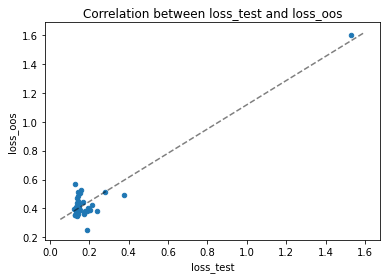

In [24]:
for m in metrics:
    make_correlation_plot(metric_df, x=m + f'_{splits[0]}', y=m + f'_{splits[1]}')

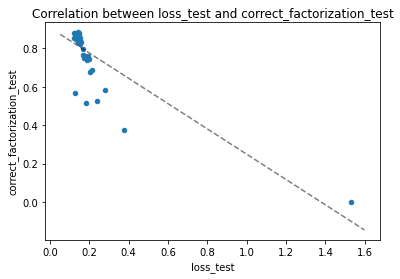

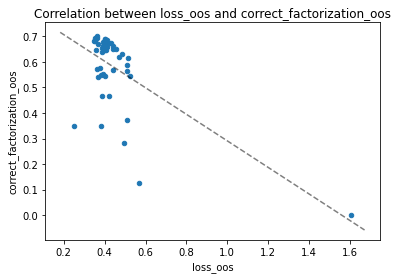

In [25]:
for m in metrics:
    if m == 'loss' : continue
    for s in splits:
        make_correlation_plot(metric_df, x=f'loss_{s}', y = f'{m}_{s}')

In [26]:
hyperparam_cols = [c for c in metric_df.columns if not c in metrics_full + ignore_cols]

In [27]:
hyperparam_cols

['base',
 'attn_weight_xavier_init_constant',
 'dim_feedforward',
 'dropout',
 'embed_dim',
 'extra_positional_encoding_relative_decoder_mha',
 'learn_positional_encoding',
 'norm_first',
 'num_decoder_layers',
 'num_encoder_layers',
 'positional_encoding_query_key_only',
 'positional_encoding_type',
 'repeat_positional_encoding',
 'scale_embeddings',
 'scale_embeddings_at_init',
 'shared_embeddings',
 'weight_decay',
 'num_warmup_steps',
 'nb_epochs',
 'num_heads']

In [28]:
metrics_lower_is_better = {'loss'}

def style_col_axis_1(col, n_highlight=3, col_id_name="id"):
#     if col.name==col_id_name:
#         return [f'background-color: {col[i]}' for i in range(len(col))]
    if len(set(col.name.split('_')).intersection(metrics_lower_is_better)):
        top_indicies = np.argsort(col.values)[:n_highlight]
    else:
        top_indicies = np.argsort(col.values)[::-1][:n_highlight]
    alphas = np.zeros(len(col))
    for i in range(len(top_indicies)):
        alphas[top_indicies[i]] = 1 - i/n_highlight
    return np.array([f'background-color: rgba(0,169,0,{alphas[i]})' for i in range(len(col))])

def style_df(df, ablated_hparams = None, n_highlight=3, col_id_name="color"):
    if ablated_hparams is None:
        ablated_hparams = []
    to_return = np.zeros_like(df.values, dtype=np.object)
    df_cols = df.columns
#     display(df)
    for i in range(df.shape[1]):
        this_col = df_cols[i]
        if this_col in ablated_hparams: continue
        if this_col in hyperparam_cols:
            to_return[:,i] = np.array([f'background-color: {df[col_id_name].iloc[j]}' for j in range(df.shape[0])])
#             print(to_return)
        else:
            to_return[:,i] = style_col_axis_1(df.iloc[:,i], n_highlight, col_id_name)
    return to_return

In [29]:
default_mapper = {
    'num_heads' : 8
}

for k, v in default_mapper.items():
    if k in metric_df:
        metric_df[k] = metric_df[k].fillna(v)
        metric_df_loss_hist[k] = metric_df_loss_hist[k].fillna(v)

In [30]:
metric_df.sort_values(hyperparam_cols).style.apply(style_col_axis_1, axis=0, subset=metrics_full)

,base,attn_weight_xavier_init_constant,dim_feedforward,dropout,embed_dim,extra_positional_encoding_relative_decoder_mha,learn_positional_encoding,norm_first,num_decoder_layers,num_encoder_layers,positional_encoding_query_key_only,positional_encoding_type,repeat_positional_encoding,scale_embeddings,scale_embeddings_at_init,shared_embeddings,weight_decay,num_warmup_steps,nb_epochs,num_heads,correct_factorization_test,loss_test,correct_factorization_oos,loss_oos
17,2,0.500000,512,0.050000,128,True,False,False,6,6,False,relative-transfxl,False,False,False,True,0.100000,6000,200,8.000000,0.567395,0.126737,0.126953,0.568875
18,3,0.500000,512,0.050000,128,True,False,False,6,6,False,relative-transfxl,False,False,False,True,0.100000,6000,200,8.000000,0.513206,0.186511,0.349121,0.250305
20,7,0.500000,512,0.050000,128,True,False,False,6,6,False,relative-transfxl,False,False,False,True,0.100000,6000,200,8.000000,0.527322,0.241610,0.347168,0.380073
3,10,0.500000,512,0.050000,128,True,False,False,2,2,False,relative-transfxl,False,False,False,True,0.100000,6000,200,8.000000,0.372495,0.376533,0.281738,0.494908
10,10,0.500000,512,0.050000,128,True,False,False,4,4,False,relative-transfxl,False,False,False,True,0.100000,6000,200,8.000000,0.678810,0.203230,0.467773,0.386910
16,10,0.500000,512,0.050000,128,True,False,False,6,6,False,relative-transfxl,False,False,False,True,0.100000,6000,200,8.000000,0.751518,0.173112,0.540527,0.366861
11,10,0.500000,512,0.050000,128,True,False,False,8,8,False,relative-transfxl,False,False,False,True,0.100000,6000,200,8.000000,0.766697,0.170748,0.572266,0.361022
0,10,0.500000,512,0.050000,128,True,False,False,10,10,False,relative-transfxl,False,False,False,True,0.100000,6000,200,8.000000,0.761536,0.176904,0.574707,0.379060
1,10,0.500000,512,0.050000,128,True,False,False,12,12,False,relative-transfxl,False,False,False,True,0.100000,6000,200,8.000000,0.738312,0.187206,0.546875,0.383010
2,10,0.500000,512,0.050000,128,True,False,False,16,16,False,relative-transfxl,False,False,False,True,0.100000,6000,200,8.000000,0.687007,0.215617,0.464844,0.421082


In [31]:
def add_identifier_for_hparam_sets(df, hparam_cols, values, col_name='color'):
    df['groupby_hps'] = df[hparam_cols].apply(lambda x: '_'.join([str(y) for y in x]), axis=1)
    df.reset_index(drop=True, inplace=True)
    
    df[col_name] = values[0]
    value_counter = 0
    df.sort_values('groupby_hps', inplace=True)
    df.reset_index(inplace=True, drop=True)
    for i in range(1, df.shape[0]):
        this_row_hps = df.iloc[i]['groupby_hps']
        prev_row_hps = df.iloc[i-1]['groupby_hps']
        if not this_row_hps==prev_row_hps:
            value_counter +=1
#         print(i, col_name, values[value_counter])
        df.loc[i, col_name] = values[value_counter%len(values)]
        if value_counter>=len(values):
            warnings.warn(f'More unique combinations of hyperparams found than unique {col_name}; {col_name} will not be unique')
    df.drop('groupby_hps', axis=1, inplace=True)
    return df


In [32]:
def drop_nonunique_hparams(df):
    for c in hyperparam_cols:
        if not c in df:
            continue
        if df[c].nunique()==1:
            df.drop(c, axis=1, inplace=True)
    return df

In [33]:
class SelfReturnDict(dict):
    def __getitem__(self, idx):
        if idx in self:
            return super().__getitem__(idx)
        return idx

In [34]:
colors = [
    'rgba(255,0,0,.5)', 
    'rgba(0,255,0,.5)',
    'rgba(0,0,255,.5)',
    'rgba(48,213,200,.5)', 
    'rgba(159,43,104,.5)', 
    'rgba(230,190,138,.5)',
    'rgba(123,255,0)'
    
    
]

def ablate_hyperparameter(metric_df, hparams, show_specific_hparams=None, show_all_other_hparams=False, show_if_nonconstant=True, sort_by='other'):
    if not sort_by in ['inputs', 'other']:
        raise ValueError('expected sortby to be inputs or other')
    id_col_name = 'color'
    if isinstance(hparams, str):
        hparams = [hparams]
    hparams = hparams
    groupby_hps = [c for c in hyperparam_cols if not c in hparams]
    grouped = metric_df.groupby(groupby_hps)
    grouped = grouped.filter(lambda x: len(x) > 1)
    grouped = add_identifier_for_hparam_sets(grouped, groupby_hps, colors, id_col_name)

    
    # Have a list of params want to show
    # Want to show just ones that have unique values
    # Show all of them
    
    if show_specific_hparams:
          if isinstance(show_specific_hparams, str):
            show_specific_hparams = [show_specific_hparams]
    else:
        show_specific_hparams = []
    
    show_cols = [c for c in grouped.columns if not (c in groupby_hps) or c==id_col_name]
    for c in groupby_hps:
        if (show_all_other_hparams) or (c in show_specific_hparams) or (show_if_nonconstant and grouped[c].nunique() > 1):
            show_cols.append(c)
            
    grouped = grouped[[c for c in show_cols]]
    if sort_by=='inputs':
        grouped.sort_values(hparams, inplace=True)
        grouped.reset_index(inplace=True, drop=True)


        
    return grouped.style.hide_columns([id_col_name]).apply(style_df, axis=None, ablated_hparams = hparams, n_highlight=1)

In [35]:
valid_markers = ['o', 's', '*', 'p', 'D']
def ablate_loss_hist_plot(metric_df, hparams, plot_metric = 'test_loss', max_imgs_per_row = 3, name_mapper = None):
    if not name_mapper:
        name_mapper = {}
    name_mapper = SelfReturnDict(name_mapper)
    if isinstance(hparams, str):
        hparams = [hparams]
    groupby_hps = [c for c in hyperparam_cols if not c in hparams + ['loss_hist']]
    if not groupby_hps:
        grouped = metric_df
    else:
        grouped = metric_df.copy().groupby(groupby_hps)
        grouped = grouped.filter(lambda x: len(x) > 1).reset_index(drop=True)
    grouped = add_identifier_for_hparam_sets(grouped, groupby_hps, valid_markers, col_name='marker')
    grouped.sort_values(hparams, inplace=True)
    grouped.reset_index(inplace=True, drop=True)
    
    
    grouped = drop_nonunique_hparams(grouped)
    grouped.reset_index(drop=True, inplace=True)
    remaining_hparams = [c for c in list(grouped) if c in hyperparam_cols]
    remaining_noninput_hparams = [p for p in remaining_hparams if not p in hparams and not p=='loss_hist']
    
    other_hyperparam_values = grouped[remaining_noninput_hparams].apply(lambda x: ', '.join([str(y) for y in x]), axis=1).unique().tolist()
    n_remaining_noninput_vals = len(other_hyperparam_values)
    
    if n_remaining_noninput_vals > 1:
        n_cols = min(max_imgs_per_row, n_remaining_noninput_vals)
        n_rows = n_remaining_noninput_vals // n_cols + int(bool(n_remaining_noninput_vals % n_cols))
        fig, ax = plt.subplots(n_rows, n_cols)
        if ax.ndim==1:
            ax = np.array([ax])
        idx_to_ax = lambda idx: ax[idx // n_cols, idx % n_cols]
        
    else:
        fig = plt.gcf()
        ax = plt.gca()
        n_rows = 1
        n_cols = 1
        def _idx_to_row_col(idx):
            assert idx == 0
            return ax
        idx_to_ax = lambda idx: _idx_to_row_col(idx)
    
    def add_plot_to_ax(sub_df, ax, title):
        for j in range(sub_df.shape[0]):
            row = sub_df.iloc[j]
            loss_hist = row['loss_hist']
            loss_hist.plot(x='step', y=plot_metric, ax=ax, label = row['mpl_label'], marker=row['marker'])
        ax.set_ylabel(plot_metric)
        ax.legend()
        ax.set_title(title)
    
    
    
    grouped['mpl_label'] = grouped[remaining_hparams].apply(lambda x: ', '.join([f"{name_mapper[c]}: {x[c]}" for c in hparams]),axis=1)
    fig.set_size_inches(6*n_cols,  6* n_rows)
    if len(remaining_noninput_hparams):
        for i, (name, sub_grouped_df) in enumerate(grouped.groupby(remaining_noninput_hparams)):
            if not isinstance(name, tuple):
                name = (name,)
            plot_title = pprint.pformat({hp : val for hp, val in zip(remaining_noninput_hparams, name)})
            add_plot_to_ax(sub_grouped_df, idx_to_ax(i), title=plot_title)
    else:
        add_plot_to_ax(grouped, idx_to_ax(0), ', '.join(hparams))
    
    
    fig.tight_layout()
    plt.show()

## "Ablate" some hyperparamaters:
* For a given set of hyperparamaters, find sets of runs where all other hyperparameters are the same, but these are varied
* Plot a loss hist curve for the same collections

In [36]:
metric_df_loss_hist

,base,attn_weight_xavier_init_constant,dim_feedforward,dropout,embed_dim,extra_positional_encoding_relative_decoder_mha,learn_positional_encoding,norm_first,num_decoder_layers,num_encoder_layers,...,shared_embeddings,weight_decay,num_warmup_steps,nb_epochs,num_heads,correct_factorization_test,loss_test,correct_factorization_oos,loss_oos,loss_hist
0,10,0.5,512,0.050,128,True,False,False,10,10,...,True,0.10,6000,200,8.0,0.761536,0.176904,0.574707,0.379060,step train_loss test_loss oos_loss 0 1...
1,10,0.5,512,0.050,128,True,False,False,12,12,...,True,0.10,6000,200,8.0,0.738312,0.187206,0.546875,0.383010,step train_loss test_loss oos_loss 0 1...
2,10,0.5,512,0.050,128,True,False,False,16,16,...,True,0.10,6000,200,8.0,0.687007,0.215617,0.464844,0.421082,step train_loss test_loss oos_loss 0 1...
3,10,0.5,512,0.050,128,True,False,False,2,2,...,True,0.10,6000,200,8.0,0.372495,0.376533,0.281738,0.494908,step train_loss test_loss oos_loss 0 1...
4,30,0.5,512,0.050,128,True,False,False,10,10,...,True,0.10,6000,200,8.0,0.862477,0.135687,0.675781,0.420128,step train_loss test_loss oos_loss 0 1...
5,30,0.5,512,0.050,128,True,False,False,12,12,...,True,0.10,6000,200,8.0,0.861111,0.143742,0.690430,0.403105,step train_loss test_loss oos_loss 0 1...
6,30,0.5,512,0.050,128,True,False,False,16,16,...,True,0.10,6000,200,8.0,0.847450,0.148542,0.586426,0.508830,step train_loss test_loss oos_loss 0 1...
7,30,0.5,512,0.050,128,True,False,False,2,2,...,True,0.10,6000,200,8.0,0.585458,0.280994,0.373535,0.511091,step train_loss test_loss oos_loss 0 1...
8,30,0.5,512,0.050,128,True,False,False,4,4,...,True,0.10,6000,200,8.0,0.796448,0.167263,0.566895,0.442286,step train_loss test_loss oos_loss 0 1...
9,30,0.5,512,0.050,128,True,False,False,8,8,...,True,0.10,6000,200,8.0,0.868094,0.140810,0.651855,0.440531,step train_loss test_loss oos_loss 0 1...


In [37]:
# display(ablate_hyperparameter(metric_df, 'max_grad_norm', sort_by='other'))
# ablate_loss_hist_plot(metric_df_loss_hist, 'max_grad_norm')
# ablate_loss_hist_plot(metric_df_loss_hist, 'max_grad_norm', 'oos_loss')


In [38]:
# sys.exit()

# Base

,base,correct_factorization_test,loss_test,correct_factorization_oos,loss_oos,num_decoder_layers,num_encoder_layers
0,10,0.761536,0.176904,0.574707,0.379060,10,10
1,30,0.862477,0.135687,0.675781,0.420128,10,10
2,10,0.738312,0.187206,0.546875,0.383010,12,12
3,30,0.861111,0.143742,0.690430,0.403105,12,12
4,10,0.687007,0.215617,0.464844,0.421082,16,16
5,30,0.847450,0.148542,0.586426,0.508830,16,16
6,10,0.372495,0.376533,0.281738,0.494908,2,2
7,30,0.585458,0.280994,0.373535,0.511091,2,2
8,10,0.678810,0.203230,0.467773,0.386910,4,4
9,30,0.796448,0.167263,0.566895,0.442286,4,4


,base,correct_factorization_test,loss_test,correct_factorization_oos,loss_oos,num_decoder_layers,num_encoder_layers
0,2,0.567395,0.126737,0.126953,0.568875,6,6
1,3,0.513206,0.186511,0.349121,0.250305,6,6
2,7,0.527322,0.241610,0.347168,0.380073,6,6
3,10,0.761536,0.176904,0.574707,0.379060,10,10
4,10,0.751518,0.173112,0.540527,0.366861,6,6
5,10,0.766697,0.170748,0.572266,0.361022,8,8
6,10,0.678810,0.203230,0.467773,0.386910,4,4
7,10,0.687007,0.215617,0.464844,0.421082,16,16
8,10,0.738312,0.187206,0.546875,0.383010,12,12
9,10,0.372495,0.376533,0.281738,0.494908,2,2


<ipython-input-31-59988385373d>:17: UserWarning: More unique combinations of hyperparams found than unique marker; marker will not be unique
  warnings.warn(f'More unique combinations of hyperparams found than unique {col_name}; {col_name} will not be unique')


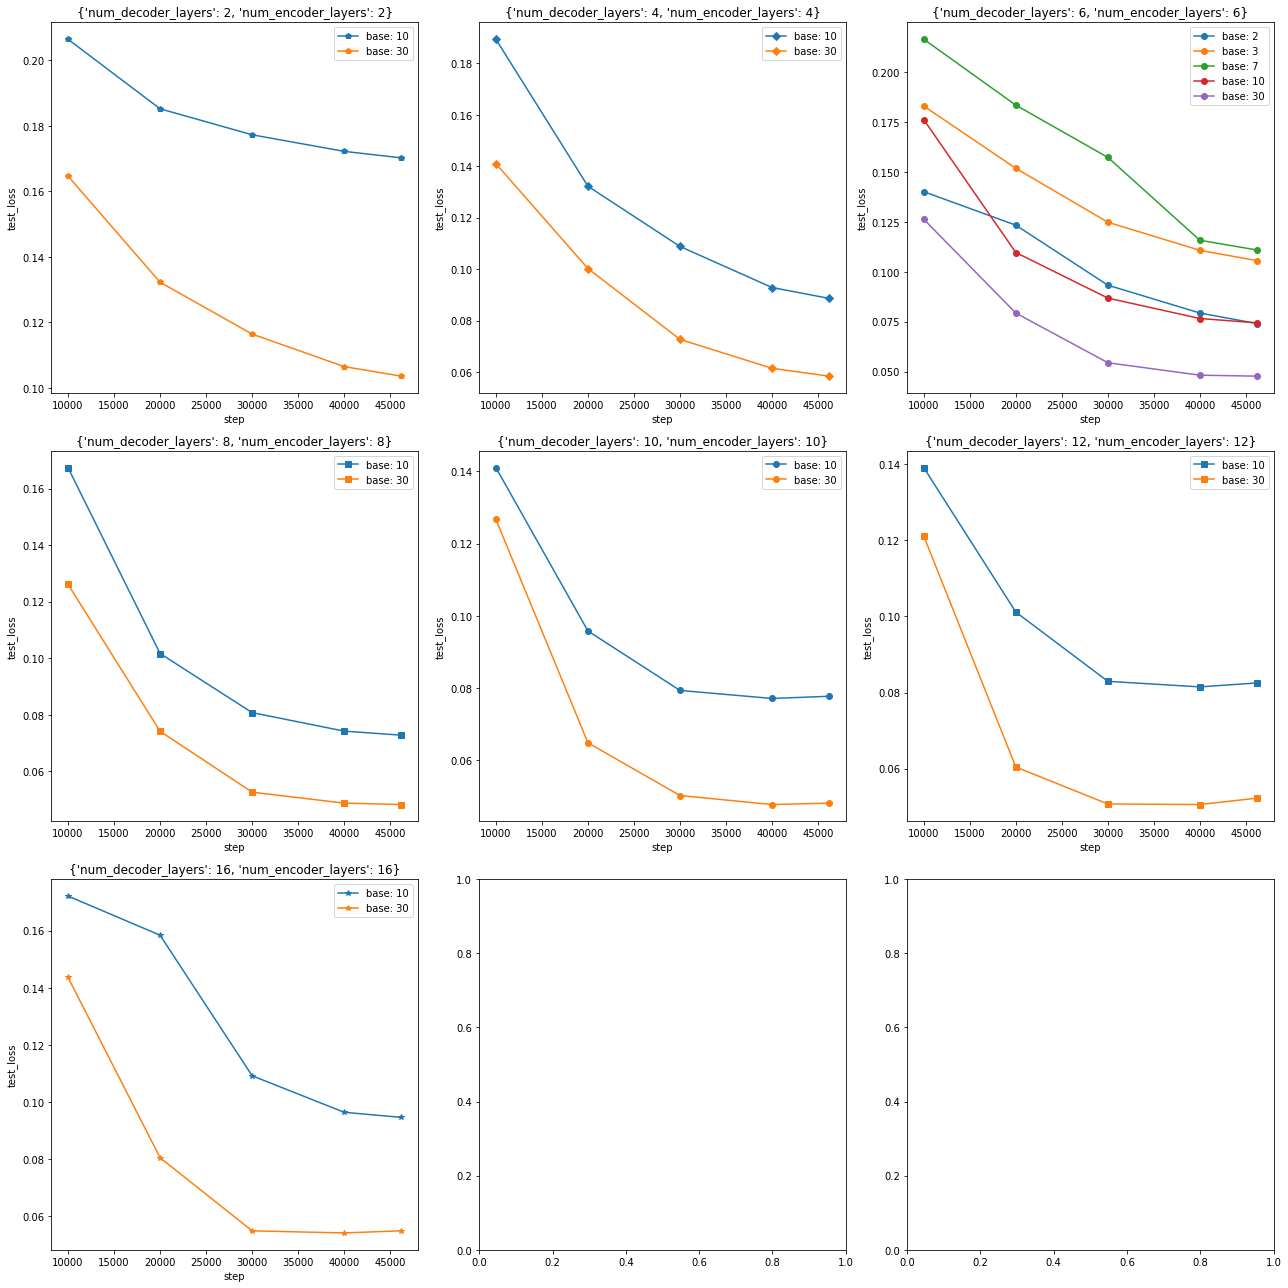

In [39]:
display(ablate_hyperparameter(metric_df, 'base', sort_by='other'))
display(ablate_hyperparameter(metric_df, 'base', sort_by='inputs'))
ablate_loss_hist_plot(metric_df_loss_hist, 'base')


# # Encoder/Decoder Layers

,num_decoder_layers,num_encoder_layers,correct_factorization_test,loss_test,correct_factorization_oos,loss_oos,base
0,2,2,0.372495,0.376533,0.281738,0.494908,10
1,2,2,0.585458,0.280994,0.373535,0.511091,30
2,4,4,0.678810,0.203230,0.467773,0.386910,10
3,4,4,0.796448,0.167263,0.566895,0.442286,30
4,6,6,0.751518,0.173112,0.540527,0.366861,10
5,6,6,0.858075,0.139744,0.671387,0.366936,30
6,8,8,0.766697,0.170748,0.572266,0.361022,10
7,8,8,0.868094,0.140810,0.651855,0.440531,30
8,10,10,0.761536,0.176904,0.574707,0.379060,10
9,10,10,0.862477,0.135687,0.675781,0.420128,30


,num_decoder_layers,num_encoder_layers,correct_factorization_test,loss_test,correct_factorization_oos,loss_oos,base
0,10,10,0.761536,0.176904,0.574707,0.379060,10
1,12,12,0.738312,0.187206,0.546875,0.383010,10
2,16,16,0.687007,0.215617,0.464844,0.421082,10
3,2,2,0.372495,0.376533,0.281738,0.494908,10
4,4,4,0.678810,0.203230,0.467773,0.386910,10
5,8,8,0.766697,0.170748,0.572266,0.361022,10
6,6,6,0.751518,0.173112,0.540527,0.366861,10
7,10,10,0.862477,0.135687,0.675781,0.420128,30
8,12,12,0.861111,0.143742,0.690430,0.403105,30
9,16,16,0.847450,0.148542,0.586426,0.508830,30


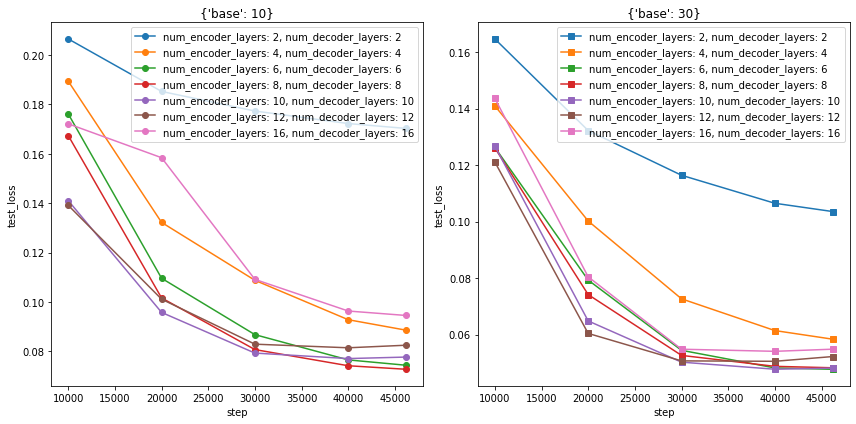

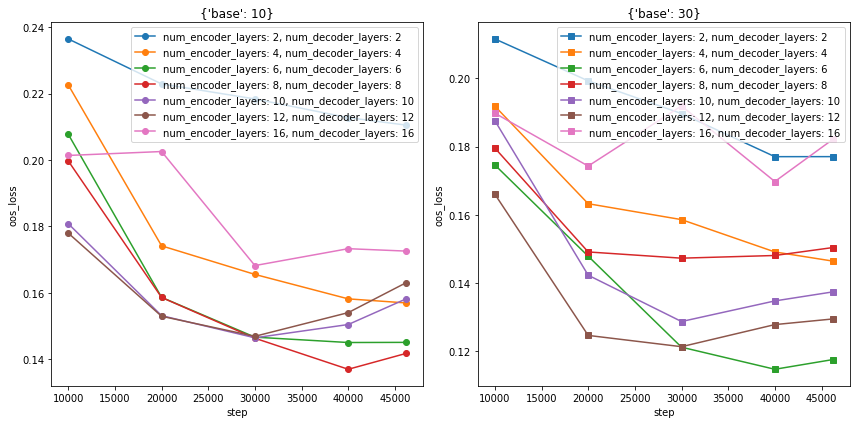

In [40]:
display(ablate_hyperparameter(metric_df, ['num_encoder_layers', 'num_decoder_layers'], sort_by='inputs'))
display(ablate_hyperparameter(metric_df, ['num_encoder_layers', 'num_decoder_layers'], sort_by='other'))
ablate_loss_hist_plot(metric_df_loss_hist, ['num_encoder_layers', 'num_decoder_layers'])
ablate_loss_hist_plot(metric_df_loss_hist, ['num_encoder_layers', 'num_decoder_layers'], 'oos_loss')

## Positional Encoding

,positional_encoding_query_key_only,positional_encoding_type,repeat_positional_encoding,correct_factorization_test,loss_test,correct_factorization_oos,loss_oos,learn_positional_encoding
0,False,absolute,False,0.855191,0.142636,0.645996,0.407953,False
1,False,absolute,True,0.832119,0.142555,0.645020,0.359572,False
2,True,absolute,True,0.866879,0.134387,0.651855,0.401963,False
3,False,relative-transfxl,False,0.858075,0.139744,0.671387,0.366936,False
4,True,absolute,True,0.867183,0.146888,0.674805,0.400644,True
5,False,relative-transfxl,False,0.867335,0.140947,0.687988,0.401454,True


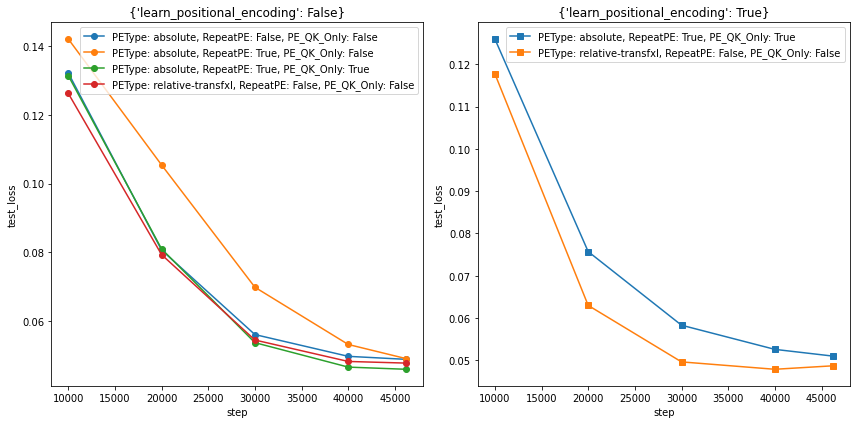

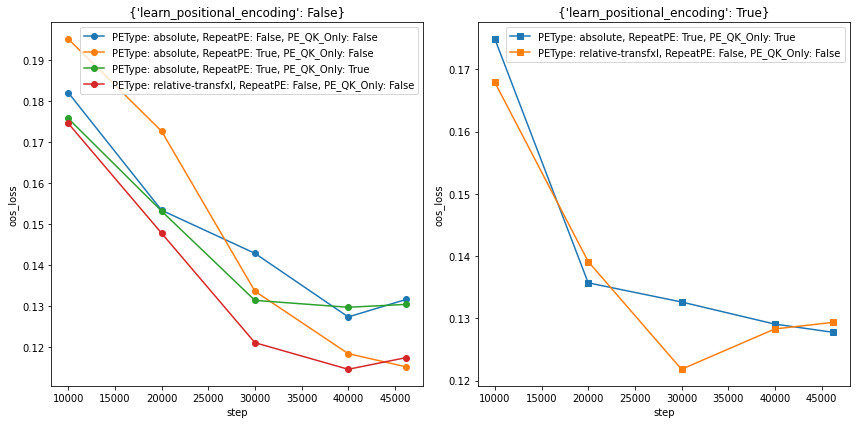

In [41]:
display(ablate_hyperparameter(metric_df, ['positional_encoding_type', 'repeat_positional_encoding', 'positional_encoding_query_key_only'], 
                      sort_by='other'))
ablate_loss_hist_plot(metric_df_loss_hist, ['positional_encoding_type', 'repeat_positional_encoding', 'positional_encoding_query_key_only'],
                     name_mapper = {
    'positional_encoding_type' : 'PEType',
    'repeat_positional_encoding' : 'RepeatPE',
    'positional_encoding_query_key_only' : 'PE_QK_Only'
})
ablate_loss_hist_plot(metric_df_loss_hist, ['positional_encoding_type', 'repeat_positional_encoding', 'positional_encoding_query_key_only'], 'oos_loss',
                     name_mapper = {
    'positional_encoding_type' : 'PEType',
    'repeat_positional_encoding' : 'RepeatPE',
    'positional_encoding_query_key_only' : 'PE_QK_Only'
})

# Learn Positional Encoding

,learn_positional_encoding,correct_factorization_test,loss_test,correct_factorization_oos,loss_oos,dropout,positional_encoding_query_key_only,positional_encoding_type,repeat_positional_encoding
0,False,0.858075,0.139744,0.671387,0.366936,0.050000,False,relative-transfxl,False
1,False,0.866879,0.134387,0.651855,0.401963,0.050000,True,absolute,True
2,False,0.842744,0.138831,0.681152,0.347193,0.100000,False,relative-transfxl,False
3,True,0.867335,0.140947,0.687988,0.401454,0.050000,False,relative-transfxl,False
4,True,0.867183,0.146888,0.674805,0.400644,0.050000,True,absolute,True
5,True,0.854281,0.135831,0.694824,0.352434,0.100000,False,relative-transfxl,False


,learn_positional_encoding,correct_factorization_test,loss_test,correct_factorization_oos,loss_oos,dropout,positional_encoding_query_key_only,positional_encoding_type,repeat_positional_encoding
0,False,0.858075,0.139744,0.671387,0.366936,0.050000,False,relative-transfxl,False
1,True,0.867335,0.140947,0.687988,0.401454,0.050000,False,relative-transfxl,False
2,False,0.866879,0.134387,0.651855,0.401963,0.050000,True,absolute,True
3,True,0.867183,0.146888,0.674805,0.400644,0.050000,True,absolute,True
4,False,0.842744,0.138831,0.681152,0.347193,0.100000,False,relative-transfxl,False
5,True,0.854281,0.135831,0.694824,0.352434,0.100000,False,relative-transfxl,False


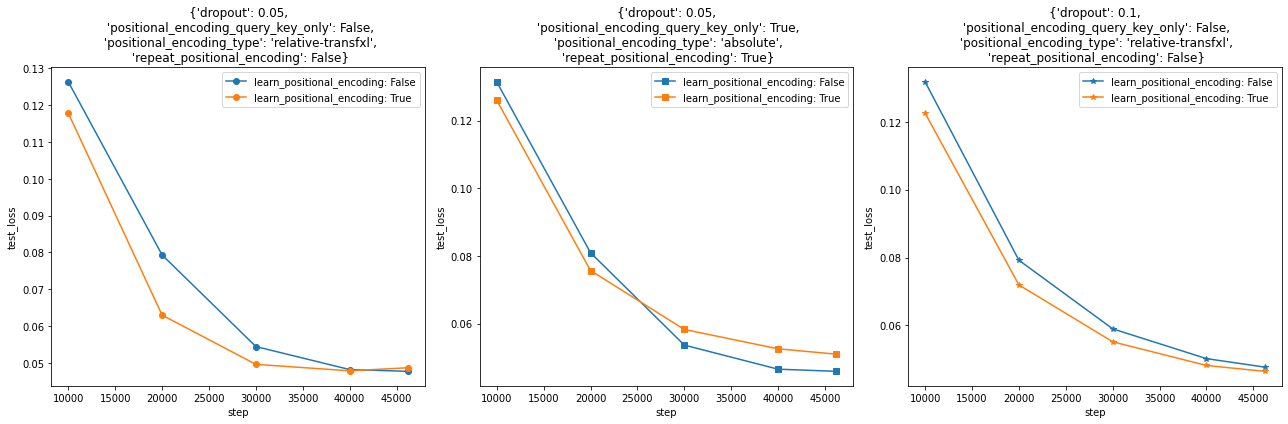

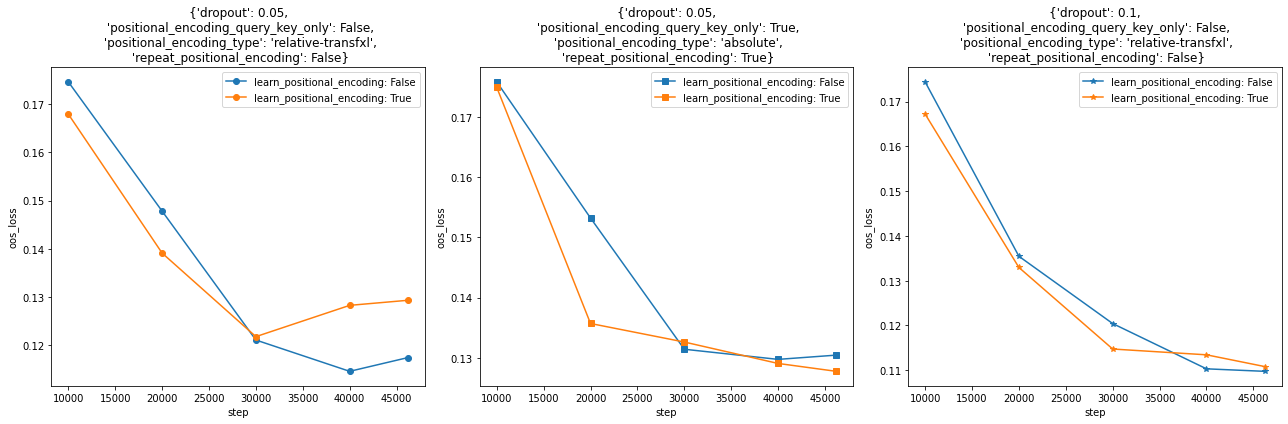

In [42]:
display(ablate_hyperparameter(metric_df, ['learn_positional_encoding'], sort_by='inputs'))
display(ablate_hyperparameter(metric_df, ['learn_positional_encoding'], sort_by='other'))
ablate_loss_hist_plot(metric_df_loss_hist, ['learn_positional_encoding'])
ablate_loss_hist_plot(metric_df_loss_hist, ['learn_positional_encoding'], 'oos_loss')

# Shared Embeddings

,shared_embeddings,correct_factorization_test,loss_test,correct_factorization_oos,loss_oos,positional_encoding_type
0,True,0.858075,0.139744,0.671387,0.366936,relative-transfxl
1,False,0.860656,0.138420,0.658203,0.409864,relative-transfxl


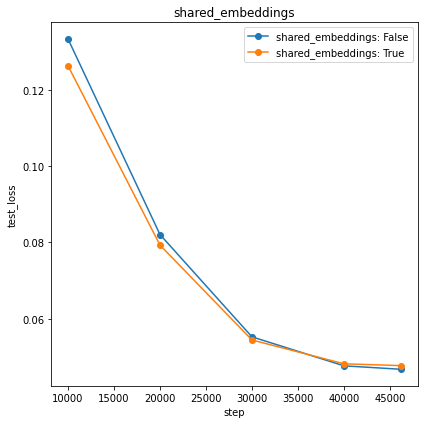

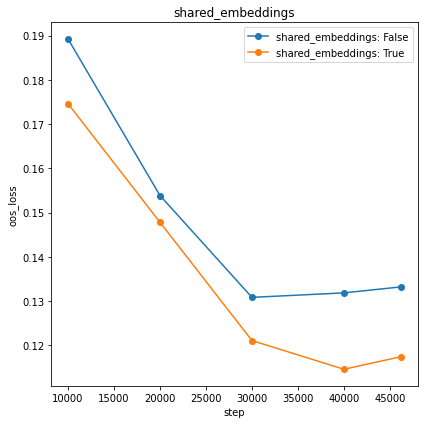

In [43]:
display(ablate_hyperparameter(metric_df, 'shared_embeddings', show_specific_hparams='positional_encoding_type'))
ablate_loss_hist_plot(metric_df_loss_hist, 'shared_embeddings')
ablate_loss_hist_plot(metric_df_loss_hist, 'shared_embeddings', 'oos_loss')

# Extra positional encodings

,extra_positional_encoding_relative_decoder_mha,correct_factorization_test,loss_test,correct_factorization_oos,loss_oos
0,False,0.853066,0.155115,0.565918,0.507397
1,True,0.858075,0.139744,0.671387,0.366936


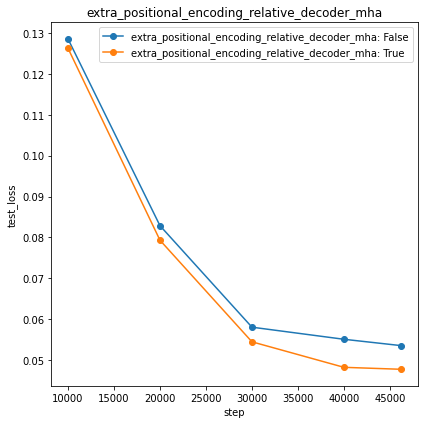

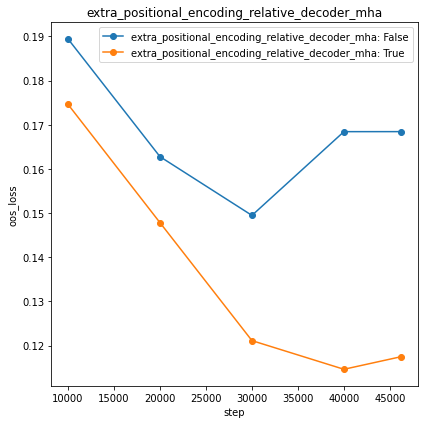

In [44]:
display(ablate_hyperparameter(metric_df, ['extra_positional_encoding_relative_decoder_mha'], sort_by='inputs'))
ablate_loss_hist_plot(metric_df_loss_hist, ['extra_positional_encoding_relative_decoder_mha'])
ablate_loss_hist_plot(metric_df_loss_hist, ['extra_positional_encoding_relative_decoder_mha'], 'oos_loss')

# Embed Dim

,embed_dim,correct_factorization_test,loss_test,correct_factorization_oos,loss_oos,num_heads
0,64,0.744687,0.197090,0.554199,0.390764,8.000000
1,128,0.854129,0.143196,0.653320,0.386098,16.000000
2,128,0.853370,0.138627,0.647461,0.400629,4.000000
3,128,0.858075,0.139744,0.671387,0.366936,8.000000
4,256,0.864602,0.142809,0.632324,0.485345,16.000000
5,256,0.880389,0.131492,0.685547,0.412846,4.000000
6,256,0.884032,0.142474,0.616211,0.512434,8.000000
7,512,0.000759,1.528364,0.000000,1.604084,8.000000
8,1024,0.000000,2.361503,0.000000,2.388436,8.000000


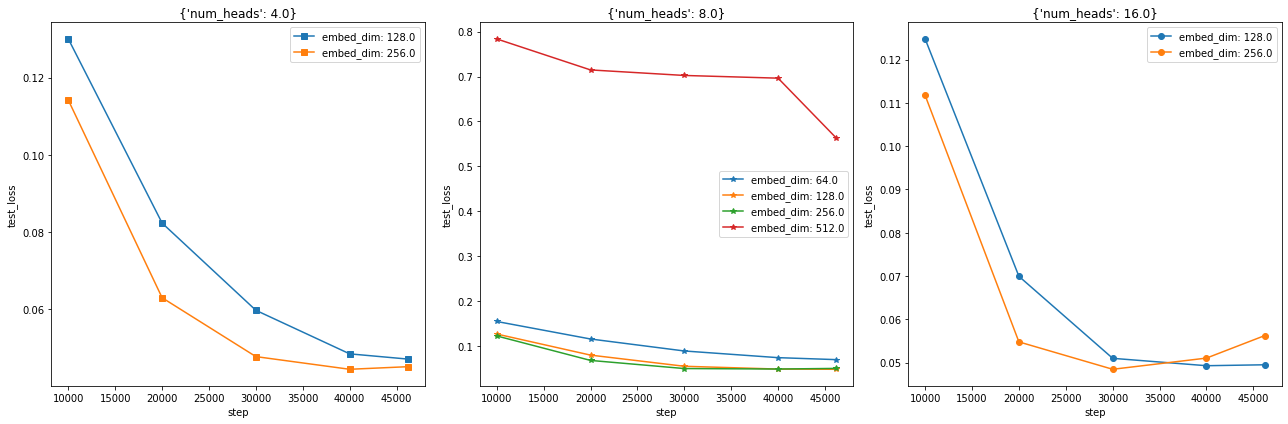

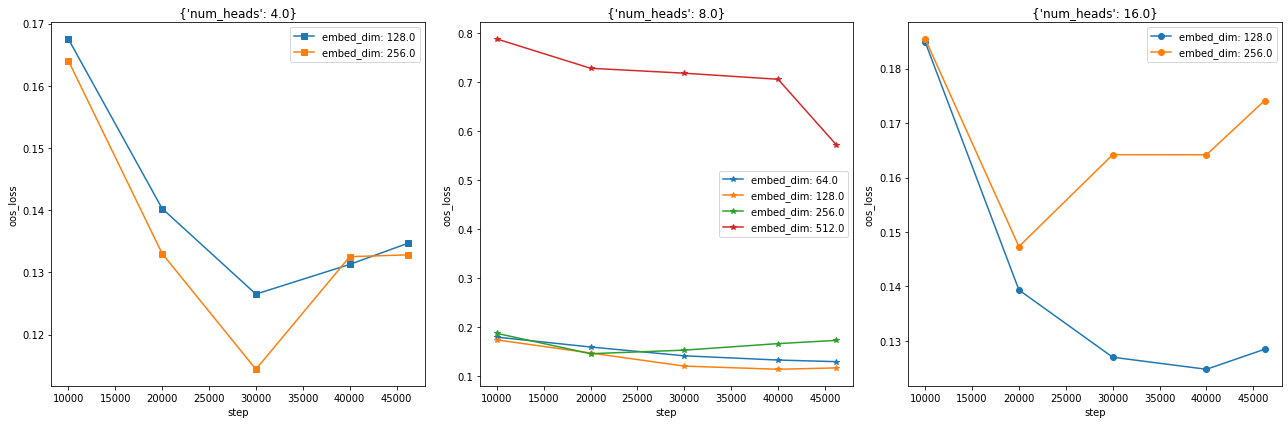

In [45]:
display(ablate_hyperparameter(metric_df, ['embed_dim'], sort_by='inputs'))
ablate_loss_hist_plot(metric_df_loss_hist[metric_df_loss_hist['embed_dim'] < 1024], ['embed_dim'])
ablate_loss_hist_plot(metric_df_loss_hist[metric_df_loss_hist['embed_dim'] < 1024], ['embed_dim'], 'oos_loss')


# Dropout

,dropout,correct_factorization_test,loss_test,correct_factorization_oos,loss_oos,learn_positional_encoding,nb_epochs
0,0.025000,0.836066,0.158501,0.545898,0.525078,False,200
1,0.050000,0.858075,0.139744,0.671387,0.366936,False,200
2,0.050000,0.868397,0.131281,0.695312,0.363390,False,400
3,0.050000,0.867335,0.140947,0.687988,0.401454,True,200
4,0.100000,0.842744,0.138831,0.681152,0.347193,False,200
5,0.100000,0.855191,0.125102,0.685547,0.354658,False,400
6,0.100000,0.854281,0.135831,0.694824,0.352434,True,200


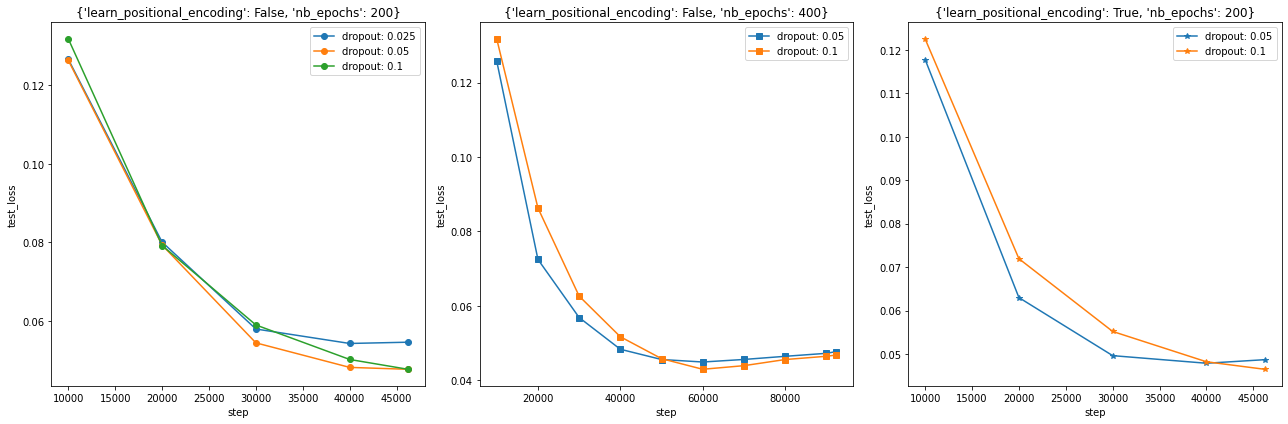

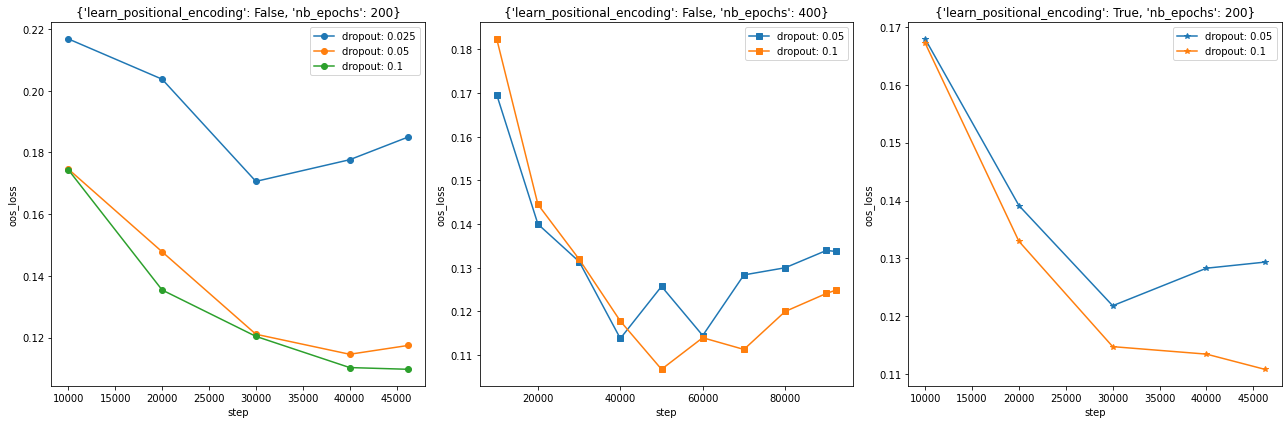

In [46]:
display(ablate_hyperparameter(metric_df, ['dropout'], sort_by='inputs'))
ablate_loss_hist_plot(metric_df_loss_hist, ['dropout'])
ablate_loss_hist_plot(metric_df_loss_hist, ['dropout'], 'oos_loss')

# Norm First

,norm_first,correct_factorization_test,loss_test,correct_factorization_oos,loss_oos
0,False,0.858075,0.139744,0.671387,0.366936
1,True,0.880237,0.147788,0.675781,0.429722


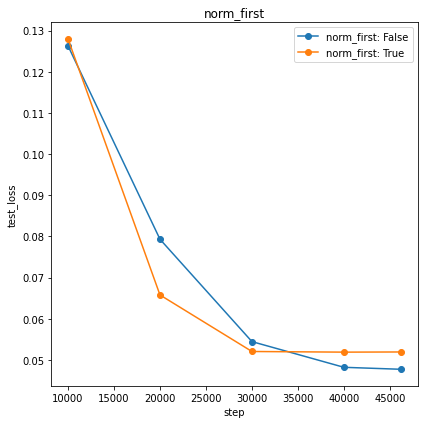

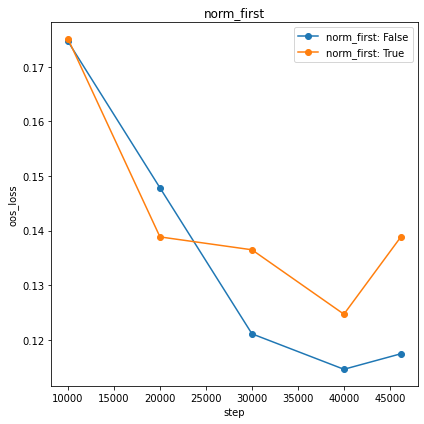

In [47]:
display(ablate_hyperparameter(metric_df, 'norm_first'))
ablate_loss_hist_plot(metric_df_loss_hist, ['norm_first'])
ablate_loss_hist_plot(metric_df_loss_hist, ['norm_first'], 'oos_loss')

# Weight Decay

,weight_decay,correct_factorization_test,loss_test,correct_factorization_oos,loss_oos,nb_epochs
0,0.100000,0.858075,0.139744,0.671387,0.366936,200
1,0.050000,0.861870,0.143647,0.669434,0.398132,200
2,0.200000,0.858986,0.126683,0.680664,0.352963,200
3,0.100000,0.868397,0.131281,0.695312,0.363390,400
4,0.200000,0.878871,0.123296,0.679688,0.394044,400


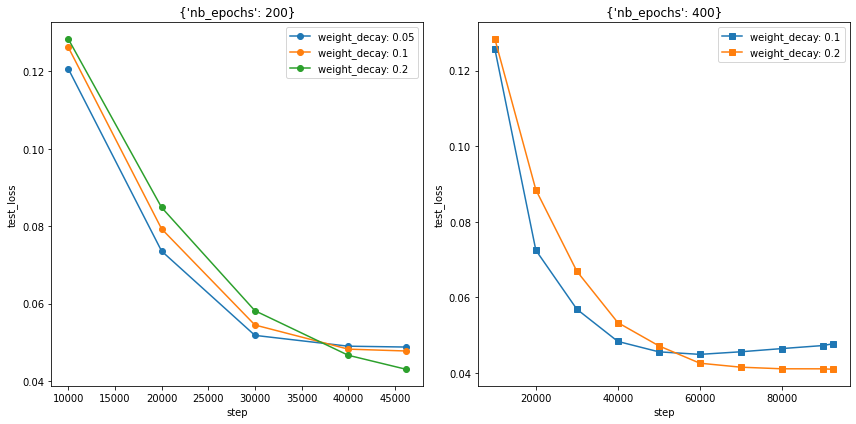

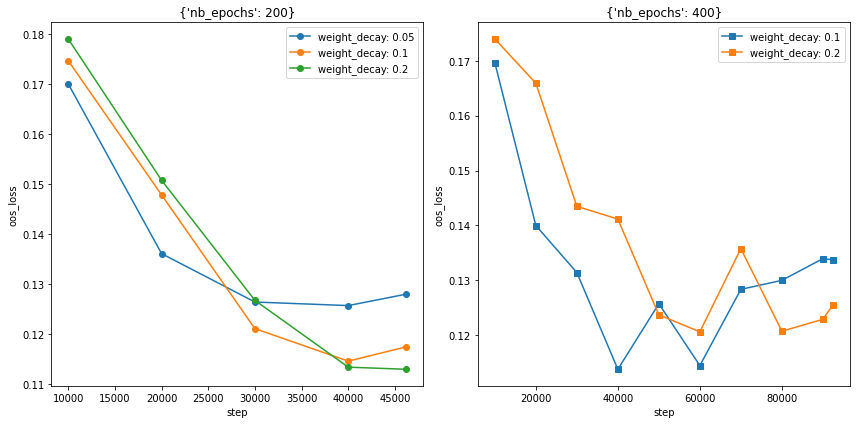

In [48]:
display(ablate_hyperparameter(metric_df, ['weight_decay']))
ablate_loss_hist_plot(metric_df_loss_hist, ['weight_decay'])
ablate_loss_hist_plot(metric_df_loss_hist, ['weight_decay'], 'oos_loss')

# Dim Feedforward

,dim_feedforward,correct_factorization_test,loss_test,correct_factorization_oos,loss_oos
0,128,0.761991,0.193407,0.542969,0.404002
1,256,0.825288,0.155413,0.638672,0.386893
2,512,0.858075,0.139744,0.671387,0.366936
3,1024,0.851852,0.135532,0.661133,0.390512
4,2048,0.874469,0.136474,0.662598,0.440355


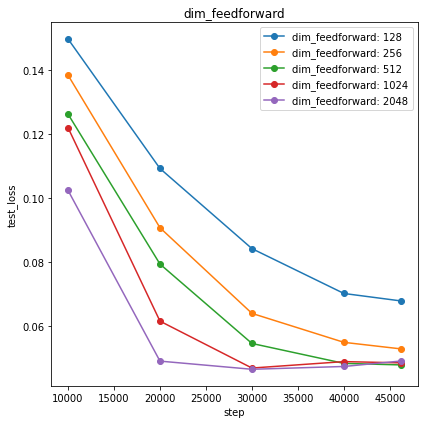

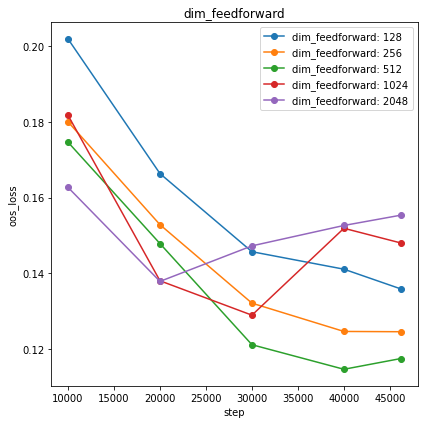

In [49]:
display(ablate_hyperparameter(metric_df, ['dim_feedforward'], sort_by='inputs'))
ablate_loss_hist_plot(metric_df_loss_hist, ['dim_feedforward'])
ablate_loss_hist_plot(metric_df_loss_hist, ['dim_feedforward'], 'oos_loss')


# Scale Embeddings

,scale_embeddings,scale_embeddings_at_init,correct_factorization_test,loss_test,correct_factorization_oos,loss_oos
0,False,False,0.858075,0.139744,0.671387,0.366936
1,True,False,0.861263,0.142503,0.651367,0.454435
2,True,True,0.867335,0.131760,0.702637,0.364757


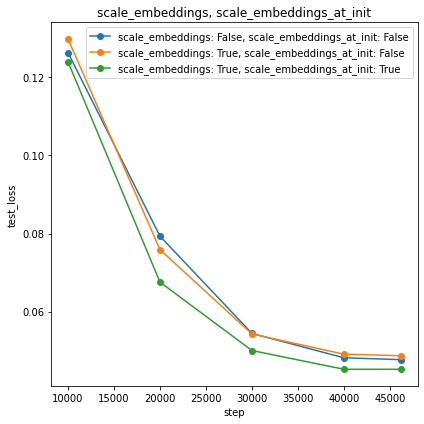

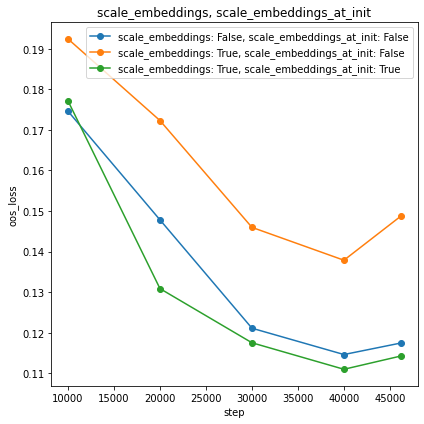

In [50]:
display(ablate_hyperparameter(metric_df, ['scale_embeddings', 'scale_embeddings_at_init'], sort_by='inputs'))
ablate_loss_hist_plot(metric_df_loss_hist, ['scale_embeddings', 'scale_embeddings_at_init'])
ablate_loss_hist_plot(metric_df_loss_hist, ['scale_embeddings', 'scale_embeddings_at_init'], 'oos_loss')

# Num Attention Heads

,num_heads,correct_factorization_test,loss_test,correct_factorization_oos,loss_oos,embed_dim
0,8.000000,0.858075,0.139744,0.671387,0.366936,128
1,16.000000,0.854129,0.143196,0.653320,0.386098,128
2,4.000000,0.853370,0.138627,0.647461,0.400629,128
3,8.000000,0.884032,0.142474,0.616211,0.512434,256
4,16.000000,0.864602,0.142809,0.632324,0.485345,256
5,4.000000,0.880389,0.131492,0.685547,0.412846,256


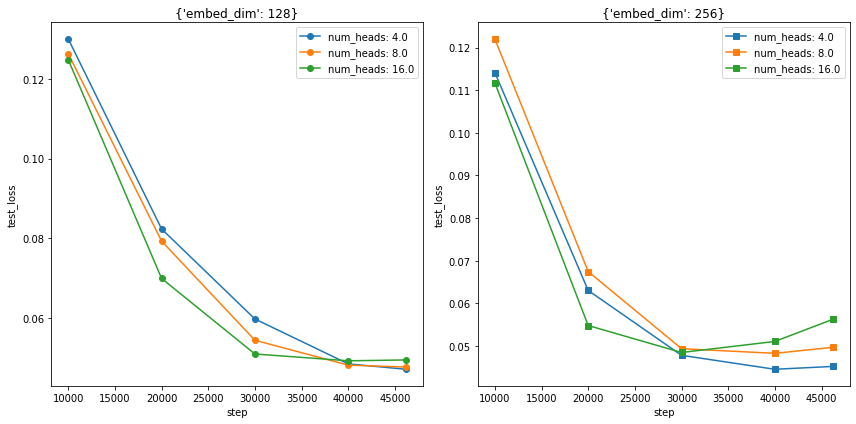

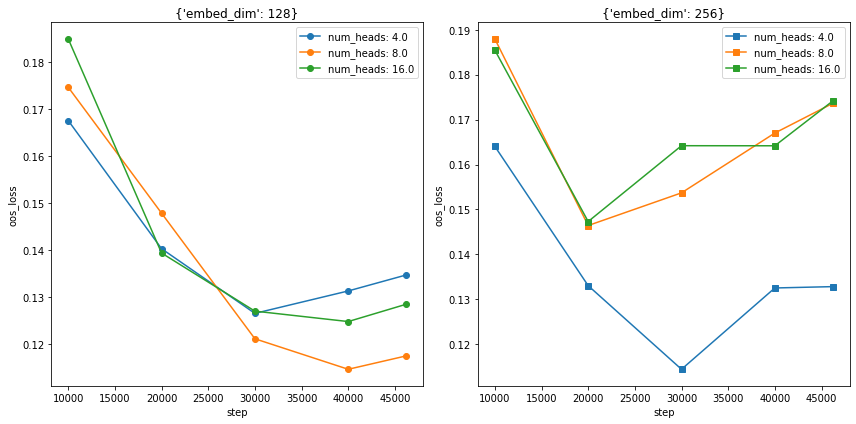

In [51]:
display(ablate_hyperparameter(metric_df, ['num_heads'], sort_by='other'))
ablate_loss_hist_plot(metric_df_loss_hist, ['num_heads'])
ablate_loss_hist_plot(metric_df_loss_hist, ['num_heads'], 'oos_loss')

# Num warmup steps

,num_warmup_steps,correct_factorization_test,loss_test,correct_factorization_oos,loss_oos
0,6000,0.858075,0.139744,0.671387,0.366936
1,10000,0.857923,0.139338,0.652344,0.397302
2,2000,0.851700,0.143614,0.660156,0.404466


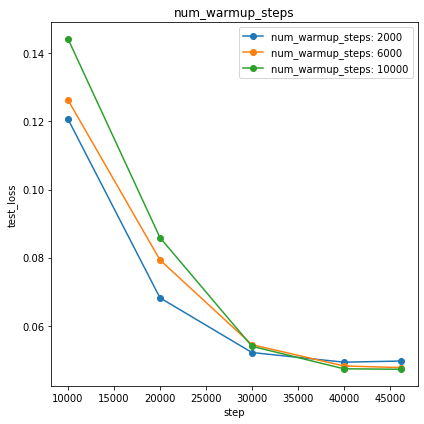

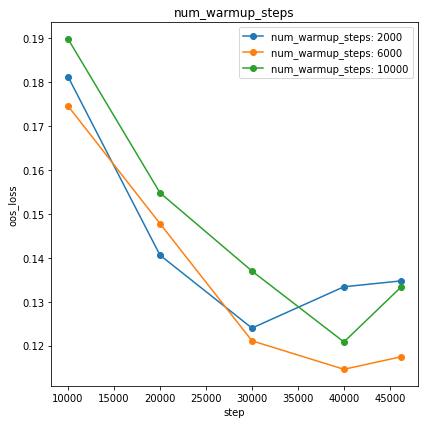

In [52]:
display(ablate_hyperparameter(metric_df, ['num_warmup_steps'], sort_by='other'))
ablate_loss_hist_plot(metric_df_loss_hist,  ['num_warmup_steps'])
ablate_loss_hist_plot(metric_df_loss_hist,  ['num_warmup_steps'], 'oos_loss')

# Nb Epochs

,nb_epochs,correct_factorization_test,loss_test,correct_factorization_oos,loss_oos,dropout,weight_decay
0,200,0.858075,0.139744,0.671387,0.366936,0.050000,0.100000
1,400,0.868397,0.131281,0.695312,0.363390,0.050000,0.100000
2,400,0.878871,0.123296,0.679688,0.394044,0.050000,0.200000
3,200,0.858986,0.126683,0.680664,0.352963,0.050000,0.200000
4,400,0.855191,0.125102,0.685547,0.354658,0.100000,0.100000
5,200,0.842744,0.138831,0.681152,0.347193,0.100000,0.100000


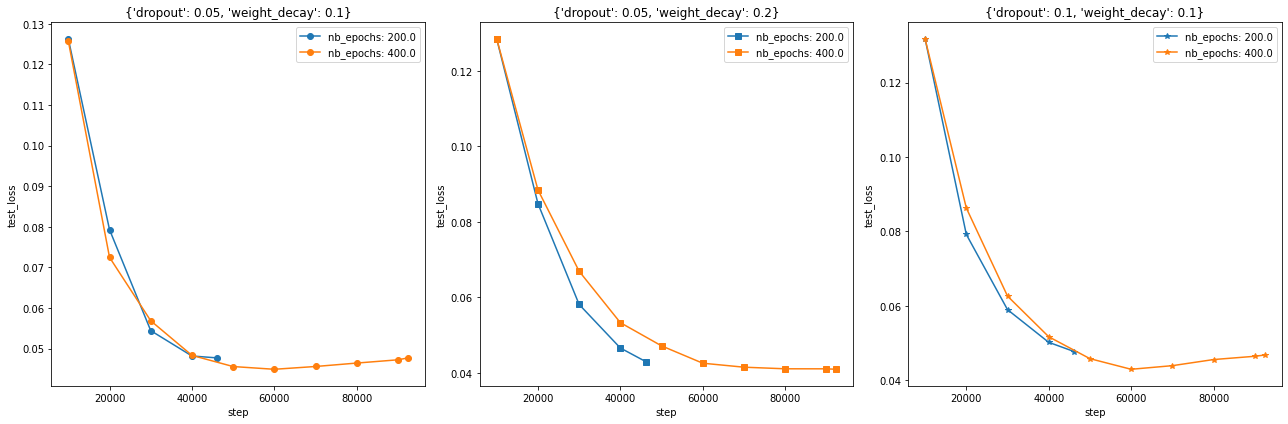

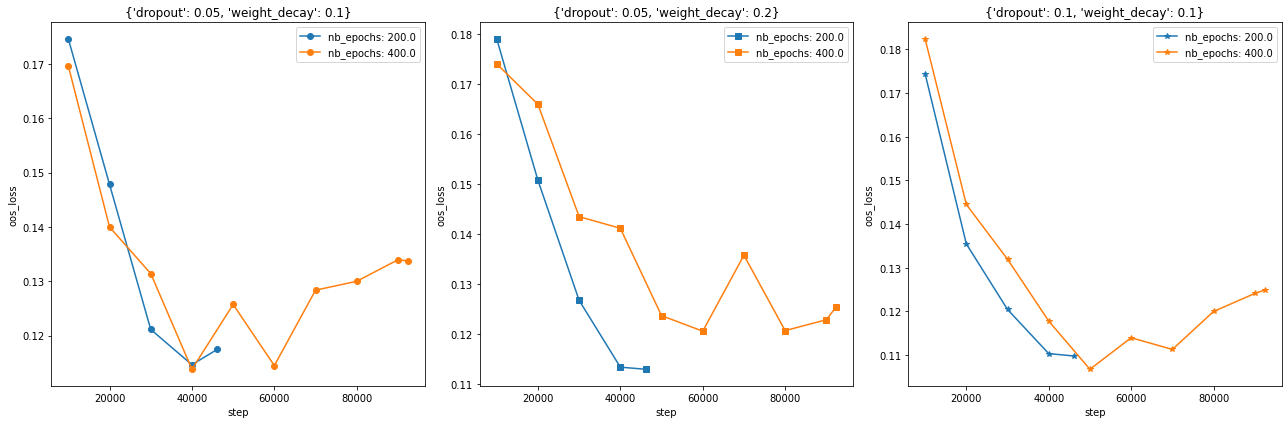

In [53]:
display(ablate_hyperparameter(metric_df, ['nb_epochs'], sort_by='other'))
ablate_loss_hist_plot(metric_df_loss_hist,  ['nb_epochs'])
ablate_loss_hist_plot(metric_df_loss_hist,  ['nb_epochs'], 'oos_loss')

,nb_epochs,correct_factorization_test,loss_test,correct_factorization_oos,loss_oos,dropout,weight_decay
0,200,0.858075,0.139744,0.671387,0.366936,0.050000,0.100000
1,400,0.868397,0.131281,0.695312,0.363390,0.050000,0.100000
2,400,0.878871,0.123296,0.679688,0.394044,0.050000,0.200000
3,200,0.858986,0.126683,0.680664,0.352963,0.050000,0.200000
4,400,0.855191,0.125102,0.685547,0.354658,0.100000,0.100000
5,200,0.842744,0.138831,0.681152,0.347193,0.100000,0.100000


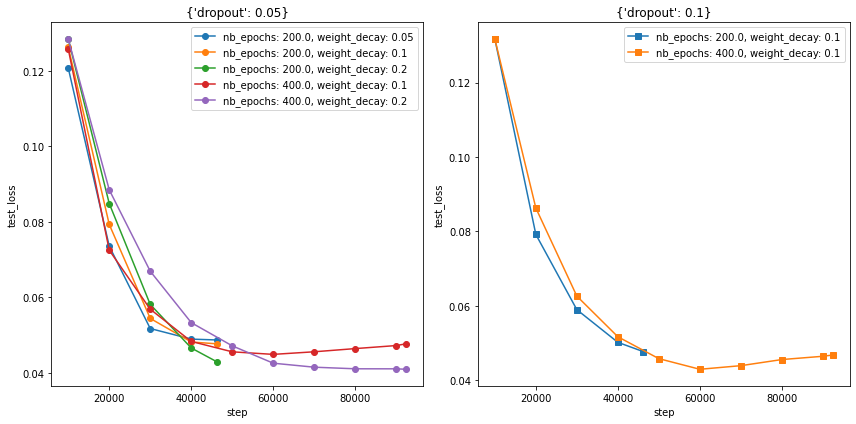

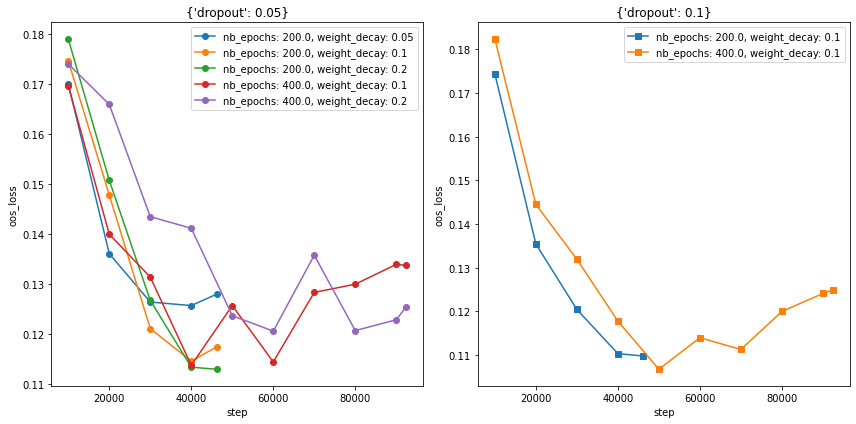

In [54]:
display(ablate_hyperparameter(metric_df, ['nb_epochs'], sort_by='other'))
ablate_loss_hist_plot(metric_df_loss_hist,  ['nb_epochs', 'weight_decay'])
ablate_loss_hist_plot(metric_df_loss_hist,  ['nb_epochs', 'weight_decay'], 'oos_loss')

,nb_epochs,correct_factorization_test,loss_test,correct_factorization_oos,loss_oos,dropout,weight_decay
0,200,0.858075,0.139744,0.671387,0.366936,0.050000,0.100000
1,400,0.868397,0.131281,0.695312,0.363390,0.050000,0.100000
2,400,0.878871,0.123296,0.679688,0.394044,0.050000,0.200000
3,200,0.858986,0.126683,0.680664,0.352963,0.050000,0.200000
4,400,0.855191,0.125102,0.685547,0.354658,0.100000,0.100000
5,200,0.842744,0.138831,0.681152,0.347193,0.100000,0.100000


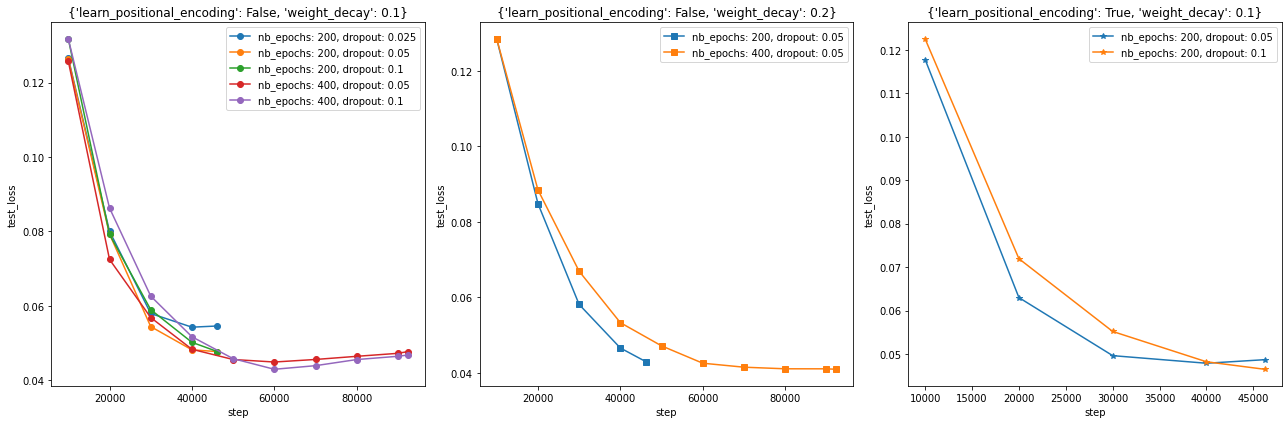

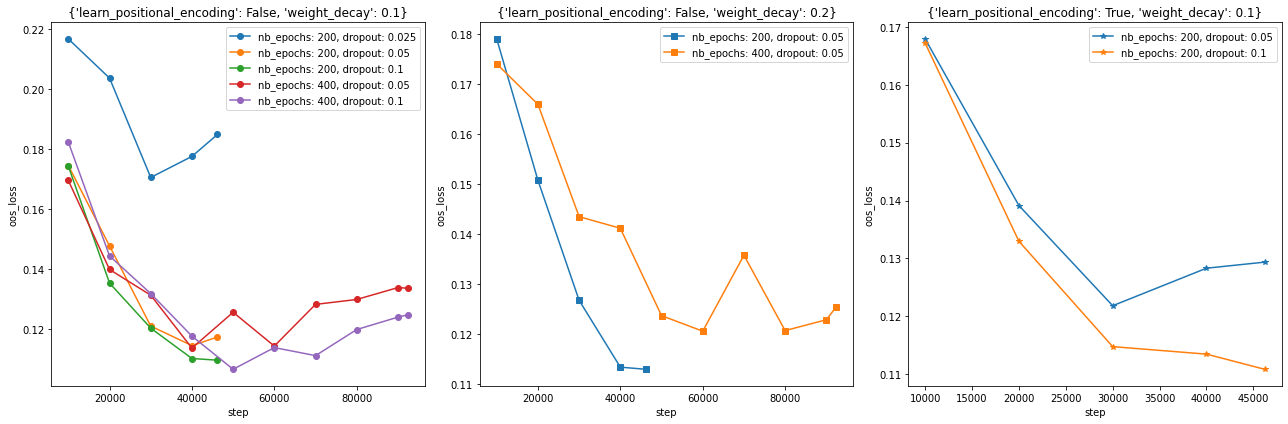

In [55]:
display(ablate_hyperparameter(metric_df, ['nb_epochs'], sort_by='other'))
ablate_loss_hist_plot(metric_df_loss_hist,  ['nb_epochs', 'dropout'])
ablate_loss_hist_plot(metric_df_loss_hist,  ['nb_epochs', 'dropout'], 'oos_loss')

### init constant

In [56]:
sys.exit()

NameError: name 'sys' is not defined

,attn_weight_xavier_init_constant,correct_factorization_test,loss_test,correct_factorization_oos,loss_oos
0,0.500000,0.858075,0.139744,0.671387,0.366936
1,1.000000,0.852004,0.138476,0.620605,0.472569


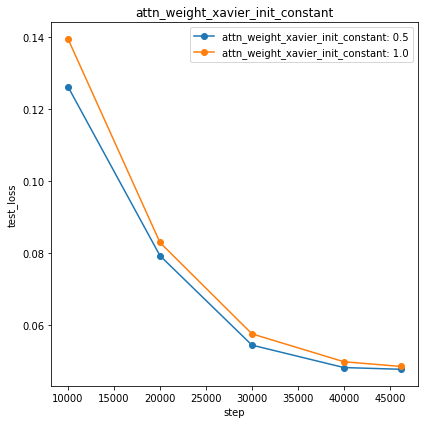

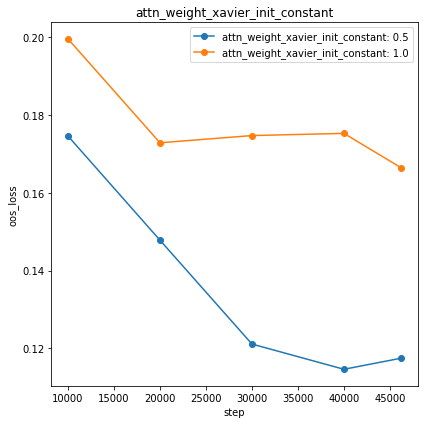

In [58]:
display(ablate_hyperparameter(metric_df, ['attn_weight_xavier_init_constant'], sort_by='other'))
ablate_loss_hist_plot(metric_df_loss_hist,  ['attn_weight_xavier_init_constant'])
ablate_loss_hist_plot(metric_df_loss_hist,  ['attn_weight_xavier_init_constant'], 'oos_loss')

### What are some hard numbers?

In [ ]:
for i in range(len(test_factor_df_list)):
    test_factor_df_list[i]['id'] = i

In [ ]:
all_factor_dfs = pd.concat(test_factor_df_list)

In [ ]:
def get_top_n_factor_dfs(n, metric = 'loss_oos', descending=False):
    ordering = np.argsort(metric_df[metric]).values
    if descending:
        ordering = ordering[::-1]
        
    top_indicies = set(list(ordering[:n]))
    
    all_factor_dfs['keep'] = all_factor_dfs.apply(lambda x: x['id'] in top_indicies, axis=1)
    subs_df = all_factor_dfs[all_factor_dfs['keep']].copy()
    
    all_factor_dfs.drop('keep', axis=1, inplace=True)
    subs_df.drop('keep', axis=1, inplace=True)
    
    return subs_df
    
    

In [ ]:
get_top_n_factor_dfs(3, 'correct_factorization_oos', descending=True)

In [ ]:
num_times_correctly_factored = all_factor_dfs.groupby(['input_num', 'id']).agg({'correct_factorization' : 'any'}).groupby(['input_num']).agg({'correct_factorization' : 'sum'})

In [ ]:
num_times_correctly_factored['correct_factorization'].hist(bins=16)

In [ ]:
num_times_correctly_factored[num_times_correctly_factored['correct_factorization']==0]

In [ ]:
num_times_correctly_factored[num_times_correctly_factored['correct_factorization']==0].reset_index()['input_num'].apply(lambda x: x % 2).value_counts()